# 4 - UTN - Breaking News -  Topic Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary

import spacy

from ast import literal_eval

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
                                                                                                                

In [2]:
df_news = pd.read_csv('news_clean.csv')
df_news                                                                                                         

,news_paper,category,date,titleandbody,titleandbody2
0,clarin,deportes,2020-03-04,"['encuentro', 'dia', 'fecha', 'equipo', 'triun...","Vélez Sarsfield vs Godoy Cruz, en vivo por la ..."
1,clarin,deportes,2020-03-04,"['espectador', 'consagracion', 'cancha', 'golp...",Cómo se prepara Atlético Tucumán para frenar a...
2,clarin,deportes,2020-03-04,"['partidos', 'marcha', 'grupo', 'conjunto', 'f...","Liga de Quito vs River, en vivo por Copa Liber..."
3,clarin,deportes,2020-03-04,"['ganas', 'manera', 'elenco', 'libertadores', ...","Ponzio, en Quito: “Hay que aprovechar nuestras..."
4,clarin,deportes,2020-03-04,"['dia', 'fin', 'ciudad', 'equipo', 'conflicto'...",La carta que jugará Neymar para irse del PSG y...
...,...,...,...,...,...
21851,lanacion,politica,2020-03-31,"['frases', 'discurso', 'continuidad', 'pandemi...",Coronavirus en la Argentina: las principales f...
21852,lanacion,politica,2020-03-31,"['rechazo', 'planteos', 'coronavirus', 'avalo'...",Coronavirus: la Justicia rechazó la mayoría de...
21853,lanacion,politica,2020-03-31,"['coronavirus', 'bloqueos', 'conurbano', 'tran...",Coronavirus: Una travesía por los bloqueos dur...
21854,lanacion,politica,2020-03-31,"['coronavirus', 'cuarentena', 'crisis', 'acuer...",Coronavirus: ¿Cómo y cuándo salir de la cuaren...


In [3]:
# C:\Users\user\UTN - Breaking News

---

En este paso se construyen el *corpus* y el *diccionario* para usar *gensim*. Para la construcción se pasa como parámetro una lista de listas de tokens.

---

In [4]:
from ast import literal_eval

tokens = df_news['titleandbody'].apply(literal_eval)

dictionary = Dictionary(tokens)
dictionary.compactify()

# Filter extremes
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.compactify()

corpus = [dictionary.doc2bow(literal_eval(text)) for text in df_news['titleandbody']]



---

# **Modelado**

A continuación se realiza la comparación de tres algoritmos de Topic Modeling: Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) y Hierarchical Dirichlet Process (HDP).
Para evaluar los modelos Topic Modeling generados se emplearán la métrica *topic coherence*, que permite medir qué tan interpretables son los tópicos para los  humanos.

---


---

# Hierarchical Dirichlet process Model

---

In [5]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary, random_state= 30)

C:\anaconda\Anaconda3\lib\site-packages\gensim\models\hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()


---

Se define la función *display_topics* 

---

In [6]:
def display_topics(model, model_type="lda"):
    for topic_idx, topic in enumerate(model.print_topics()):
        print ("Topic %d:" % (topic_idx))
        if model_type== "hdp":
            print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
        else:
            print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")

In [7]:
display_topics(hdpmodel, model_type="hdp")

Topic 0:
coronavirus  personas  millones  casos  medidas  tiempo  parte  datos  momento  virus 

Topic 1:
coronavirus  casos  personas  presidente  medidas  caso  virus  momento  aislamiento  cuarentena 

Topic 2:
coronavirus  equipo  momento  tiempo  futbol  presidente  vez  personas  boca  jugadores 

Topic 3:
coronavirus  personas  datos  presidente  vez  millones  parte  casos  sistema  medidas 

Topic 4:
millones  coronavirus  datos  cuenta  favor  casilla  notas  riesgo  presidente  equipo 

Topic 5:
dia  notas  melodia  millones  cuenta  datos  equipo  coronavirus  calendario  favor 

Topic 6:
coronavirus  datos  cuenta  favor  casilla  notas  marzo  equipo  futbol  presidente 

Topic 7:
compra  cuenta  marzo  dolar  pesos  valor  precio  datos  favor  casilla 

Topic 8:
coronavirus  cuenta  favor  notas  datos  casilla  gente  momento  marzo  casa 

Topic 9:
cuenta  tiempo  favor  datos  casilla  notas  equipo  gente  problemas  mundo 

Topic 10:
coronavirus  torneo  cuenta  ab

---

Se define la función *evaluate_graph* para evaluar la metrica de coherencia de los modelos. 

---

In [8]:
def evaluate_graph(dictionary, corpus, texts, limit, model):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
            lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        else:
            lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=30) # agrego random_state=30
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.grid()
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

---

# LSI MODEL

---

In [9]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [10]:
display_topics(lsimodel)  

Topic 0:
coronavirus personas casos medidas virus presidente tiempo momento millones caso 

Topic 1:
coronavirus casos equipo tiempo personas virus vez futbol juego jugadores 

Topic 2:
millones empresas equipo coronavirus futbol datos crisis casos jugadores boca 

Topic 3:
presidente personas coronavirus datos uso medidas equipo futbol red crisis 

Topic 4:
coronavirus presidente millones equipo mujeres virus huawei medidas mujer aislamiento 

Topic 5:
casos huawei coronavirus millones equipo virus caso casa equipos personas 

Topic 6:
millones huawei presidente casos equipo equipos proyecto documentos datos empresas 

Topic 7:
personas casos datos modo gente huawei cuenta uso luz coronavirus 

Topic 8:
mujeres mujer huawei medidas violencia virus personas coronavirus juego vida 

Topic 9:
presidente datos millones empresas personas medidas precios caso productos red 



---

En estos 10 tópicos aparecen palabras claves relacionadas con coronavirus, presidente, millones, casos, mujeres. No resulta sencillo identificar temas claves, por lo que será necesario elegir el mejor número de tópicos vigilando el valor de coherencia.

---

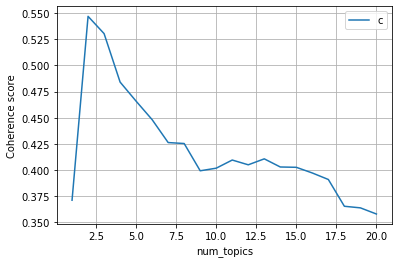

Wall time: 12min 49s


In [11]:
%%time
lmlist_lsi, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['titleandbody'].apply(literal_eval),
                                 limit=21, model= "lsi")


---

Según la coherencia el mejor número de tópicos es 2. Seleccionaremos el número de tópicos realizando una inspección visual de la coherencia.

---

In [12]:
display_topics(lmlist_lsi[1])

Topic 0:
coronavirus personas casos medidas virus presidente tiempo momento millones caso 

Topic 1:
coronavirus casos equipo tiempo personas virus vez futbol juego jugadores 



---

# Latent Dirichlet Allocation Model

---

In [13]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary, random_state=30)

In [14]:
display_topics(ldamodel)

Topic 0:
millones presidente crisis empresas pago precios semana sector pesos mes 

Topic 1:
equipo juego jugadores tiempo equipos partidos futbol momento presidente partido 

Topic 2:
mujeres presidente proyecto derechos violencia campo mujer genero senador paro 

Topic 3:
coronavirus casa personas gente virus cuarentena momento casos tiempo dia 

Topic 4:
videojuegos moto horas robots vez parte publicaciones equipo minutos robot 

Topic 5:
presidente vez cosas tiempo vida juez justicia cambio parte proyecto 

Topic 6:
personas casos aislamiento cuarentena presidente caso coronavirus vuelos ciudad medidas 

Topic 7:
coronavirus virus personas manos alcohol productos medidas respiradores horas gente 

Topic 8:
datos sistema uso forma empresas red aplicaciones calidad usuario servicios 

Topic 9:
coronavirus medidas casos personas presidente pandemia virus salud emergencia marzo 



---

Se intenta hallar el número óptimo de tópicos para este modelo basado en la métrica coherencia.

---

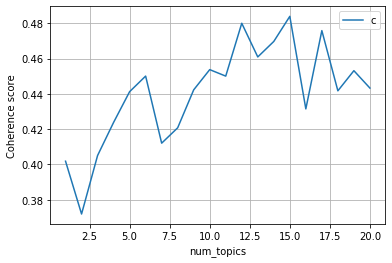

Wall time: 29min 26s


In [15]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['titleandbody'].apply(literal_eval),
                             limit=21, model= "lda")


---

Para este modelo el número óptimo de tópicos se ubica entre 12 y  15

---

---

## Evaluación de la coherencia de los mejores modelos

Se elige una instancia de cada modelo teniendo en cuenta la métrica de coherencia. 

Se compara luego la coherencia entre ellos.

---

In [16]:
ldamodel = lmlist[11]
lsimodel = lmlist_lsi[1]

lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [17]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=df_news['titleandbody'].apply(literal_eval),
                               dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=df_news['titleandbody'].apply(literal_eval),
                               dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=df_news['titleandbody'].apply(literal_eval),
                               dictionary=dictionary, window_size=10).get_coherence()

C:\anaconda\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


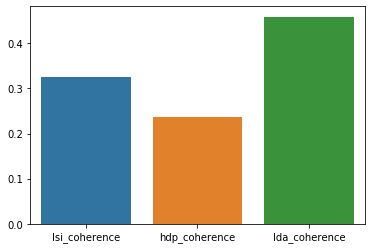

In [18]:
import seaborn as sns

coherences = [lsi_coherence, hdp_coherence, lda_coherence]
n = len(coherences)
x = ['lsi_coherence','hdp_coherence', 'lda_coherence']
sns.barplot(x, coherences);

Se observa en la gráfica que el modelo LDA con 12 tópicos tiene el mayor nivel de coherencia.

---


Se examinan las palabras clave de los tópicos del mejor modelo

---

In [19]:
display_topics(ldamodel)

Topic 0:
millones presidente jueces ley ministro pago mes pesos semana funcionarios 

Topic 1:
equipo juego jugadores videojuegos tiempo equipos mundo partidos momento futbol 

Topic 2:
mujeres presidente proyecto derechos violencia mujer genero senador cambio mensaje 

Topic 3:
coronavirus casa personas casos gente cuarentena momento dia aislamiento tiempo 

Topic 4:
moto horas coronavirus vuelo marzo minutos parte semana vez momento 

Topic 5:
tiempo vez cosas juez vida presidente justicia causa casa parte 

Topic 6:
personas vuelos aislamiento cuarentena presidente pasajeros caso medidas casos horas 

Topic 7:
coronavirus virus personas manos casos alcohol medidas respiradores salud caso 

Topic 8:
datos sistema uso forma red coronavirus aplicaciones calidad usuario personas 

Topic 9:
coronavirus medidas casos presidente personas pandemia salud virus emergencia provincia 

Topic 10:
alimentos personas distancia accesos gente supermercados aislamiento productos semana calles 

Topic


---

## Clasificación de las noticias

---



---

Se seleccionó como modelo que mejor se adapta LDA y como número óptimo de tópicos 12.

Se asigna un tópico a cada noticia, es decir, se agrupan las noticias según los tópicos.

---

In [20]:
def format_topics_sentences(ldamodel=0, corpus=corpus, texts=0):
    # Init output
    sent_topics_df = pd.DataFrame()-n

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), 
                                                                  topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel, corpus=corpus, texts=df_news['titleandbody'].apply(literal_eval))

In [21]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.sample(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
12877,12877,6.0,0.5580,"personas, vuelos, aislamiento, cuarentena, pre...","[penas, cuarentena, coronavirus, urgencia, pis..."
453,453,3.0,0.8367,"coronavirus, casa, personas, casos, gente, cua...","[casa, coronavirus, lunes, marzo, regata, dia,..."
17276,17276,6.0,0.3235,"personas, vuelos, aislamiento, cuarentena, pre...","[coronavirus, barrios, barrio, propietarios, p..."
10317,10317,9.0,0.4892,"coronavirus, medidas, casos, presidente, perso...","[coronavirus, virus, entidad, canal, asiduos, ..."
17064,17064,7.0,0.4066,"coronavirus, virus, personas, manos, casos, al...","[policias, momentos, objetivo, propagacion, vi..."
15580,15580,3.0,0.4775,"coronavirus, casa, personas, casos, gente, cua...","[caso, coronavirus, responsable, confirmarse, ..."
16028,16028,2.0,0.7901,"mujeres, presidente, proyecto, derechos, viole...","[mujeres, violencia, favor, lluvia, marea, zon..."
199,199,5.0,0.6050,"tiempo, vez, cosas, juez, vida, presidente, ju...","[drogas, dirigentes, dinero, futbolista, crack..."
9971,9971,9.0,0.4225,"coronavirus, medidas, casos, presidente, perso...","[casos, coronavirus, infectados, casos, cifra,..."
5192,5192,5.0,0.7206,"tiempo, vez, cosas, juez, vida, presidente, ju...","[tiempo, prision, noche, manera, contacto, det..."


---

Se mapea cada tópico con una etiqueta que lo describe.

Primero se crea el diccionario.

---

In [22]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype('int64')


In [23]:
label_dicc = {0:'politica', 1:'deportes', 2: 'mujer', 3:'coronavirus', 4: 'actualidad', 5:'justicia',
             6:'aislamiento', 7:'salud', 8: 'tecnologia', 9:'pandemia', 10: 'sociedad', 11:'economia'}



Topic 0:
millones presidente jueces ley ministro pago mes pesos semana funcionarios 

Topic 1:
equipo juego jugadores videojuegos tiempo equipos mundo partidos momento futbol 

Topic 2:
mujeres presidente proyecto derechos violencia mujer genero senador cambio mensaje 

Topic 3:
coronavirus casa personas casos gente cuarentena momento dia aislamiento tiempo 

Topic 4:
moto horas coronavirus vuelo marzo minutos parte semana vez momento 

Topic 5:
tiempo vez cosas juez vida presidente justicia causa casa parte 

Topic 6:
personas vuelos aislamiento cuarentena presidente pasajeros caso medidas casos horas 

Topic 7:
coronavirus virus personas manos casos alcohol medidas respiradores salud caso 

Topic 8:
datos sistema uso forma red coronavirus aplicaciones calidad usuario personas 

Topic 9:
coronavirus medidas casos presidente personas pandemia salud virus emergencia provincia 

Topic 10:
alimentos personas distancia accesos gente supermercados aislamiento productos semana calles 

Topic 11:
empresas crisis millones precios sector mercado empresa precio actividad sectores 


---

Luego se realiza el mapeo.

---

In [24]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].map(label_dicc)
df_dominant_topic.sample(30)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
2397,2397,coronavirus,0.9365,"coronavirus, casa, personas, casos, gente, cua...","[paciente, hospital, paciente, coronavirus, mu..."
14215,14215,deportes,0.5142,"equipo, juego, jugadores, videojuegos, tiempo,...","[mariano, videos, pandemia, parte, prensa, inc..."
3757,3757,politica,0.5664,"millones, presidente, jueces, ley, ministro, p...","[fallo, puerta, pago, sueldos, legisladores, p..."
7014,7014,salud,0.4289,"coronavirus, virus, personas, manos, casos, al...","[gesto, pandemia, cuarentena, casos, pandemia,..."
20932,20932,aislamiento,0.5494,"personas, vuelos, aislamiento, cuarentena, pre...","[tema, restricciones, medidas, propagacion, cu..."
233,233,deportes,0.5304,"equipo, juego, jugadores, videojuegos, tiempo,...","[cantidad, descensos, regreso, fin, calle, dir..."
21690,21690,pandemia,0.5375,"coronavirus, medidas, casos, presidente, perso...","[advertencia, empresarios, presidente, dureza,..."
20661,20661,justicia,0.6343,"tiempo, vez, cosas, juez, vida, presidente, ju...","[socios, enemigos, votos, ganado, provincia, p..."
1599,1599,economia,0.5314,"empresas, crisis, millones, precios, sector, m...","[pese, zarpo, barco, martes, madrugada, muelle..."
5692,5692,deportes,0.5265,"equipo, juego, jugadores, videojuegos, tiempo,...","[fracasos, campa, equipo, octavos, supero, cua..."


In [25]:
df_news['Tópicos'] = df_dominant_topic['Dominant_Topic']

---

Se visualizan algunas noticias y su tópico asociado.

---

In [26]:
pd.set_option('display.max_colwidth', 300)

In [27]:
df_news[['titleandbody2', 'Tópicos']].sample(10)
#df_news[['titleandbody2', 'Tópicos']][df_news['Tópicos']=='deportes'].head(50)

,titleandbody2,Tópicos
18315,"Command & Conquer: 25 años después, vuelve para dar batalla en 4K // Electronic Arts (EA) \r\n\r\nha anunciado que la remasterización\r\n\r\n del clásico videojuego de Estrategia en Tiempo Real (RTS, según sus siglas en inglés) \r\n\r\nCommand & Conquer\r\n\r\n estará disponible el \r\n\r\npróxi...",deportes
5601,"Prohíben pelear por dos meses a la luchadora de UFC a la que se le deformó el rostro tras una pelea // Este fin de semana la china Weili Zhang retuvo el título de peso minimosca al vencer por decisión de los jueces a Joanna Jedrzejczyk, en uno de los combates previos al de Israel Adesanya y Yoel...",deportes
9760,"Pidió plata prestada, viajó doce horas en Uber y durmió en el piso para poder volver a Buenos Aires // Juan García (35) no puede contener las lágrimas. Varias veces interrumpe su relato. “Dame un segundo, no estoy bien. La situación me supera. Quiero llegar a casa”, dice desde Puerto Iguazú, uno...",actualidad
19067,"Cómo hacer un uso responsable de Internet en tiempos de mayor demanda de la red // ""A la gente que está normalmente en la casa, hay que sumarle la nueva, y los chicos y sobre todo aquellos que se quedan jugando o consumiendo por \r\n \r\n \r\nstreaming\r\n\r\n \r\n\r\n en el...",tecnologia
3650,"El nuevo mensaje de Alberto Fernández a los empresarios por el precio de los alimentos: “Voy a ser implacable” // El presidente Alberto Fernánde<U+200B>z le envió este miércoles un nuevo mensaje a los empresarios al advertir que será ""implacable"" e ""inflexible"" con aquellos que continúen aumenta...",economia
1086,"Dólar turista hoy: cuál es la cotización este lunes 9 de marzo // Hoy lunes 9 de marzo, el dólar oficial cotiza en promedio a 59,71 pesos para la compra y 64,71 pesos para la venta, por lo que el valor del dólar turista está en 84,12 pesos. El precio ha subido algunos centavos con respecto a las...",economia
642,"Defensa y Justicia deberá pagar una multa de 20.000 dólares por los gestos racistas de un hincha // El episodio de racismo por parte de un hincha de Defensa y Justicia durante el partido que el Halcón perdió el 3 de marzo ante Santos en Florencio Varela, por la Copa Libertadores, le salió bastan...",deportes
7796,"Desde que asumió el gobierno, el BCRA debió emitir $ 327.000 millones para ayudar al Tesoro a pagar vencimientos en pesos // Desde el 10 de diciembre de 2019, cuando Alberto Fernández asumió la presidencia de la Nación, el Banco Central debió asistir al Tesoro de la Nación en 327.000 millones de...",politica
5605,"El momento en el que suspenden un partido de la NBA a punto de comenzar porque un jugador dio positivo coronavirus // El Chesapeake Arena estaba completo, a la espera del duelo entre el local, Oklahoma City Thunder, y Utah Jazz, por una nueva jornada de la NBA. Ya estaban dispuestos los cinco ju...",deportes
21048,"Coronavirus: la oposición apoya al Presidente, pero alerta sobre los efectos económicos // No hay una sola voz en la oposición que en público no declame el apoyo al Gobierno y su decisión de imponer la cuarentena obligatoria para enfrentar el brote de coronavirus en el país. En plena emergencia ...",politica


In [28]:
df_news[ df_news['Tópicos'] == 'coronavirus'].titleandbody2[2487]

'Coronavirus en Argentina: confirman 36 nuevos casos y ya son 301 los contagiados // Con el último reporte oficial, en el que se confirmaron 36 nuevos casos de coronavirus, el número de infectados en el país ascendió a 301, contando los cuatro fallecidos. A Capital, Provincia de Buenos Aires, Córdoba y Chaco, que venían siendo las zonas más complicadas, ahora se suma Santa Fe que en un solo día registró 13 afectados. El otro factor que preocupa es que la "transmisión comunitaria" ya es una realidad en Argentina, según expresó este lunes Carla Vizzoti, secretaria de Acceso a la Salud. Sostener el "aislamiento social" y mantener los dos metros de distancia al momento de salir a comprar es clave para prevenir, según destaca a Clarín el infectólogo Eduardo López. Higienizar bien los productos que ingresan al hogar es la otra recomendación a tener en cuenta. Las autoridades sanitarias contabilizaron 13 casos nuevos en Santa Fe, 11 en la Ciudad, cinco en la Provincia, cuatro en Chaco y otros

---

Se visualiza la distribución de tópicos

---

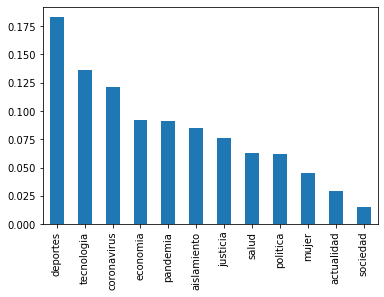

In [29]:
ax = df_dominant_topic['Dominant_Topic'].value_counts(normalize=True).plot(kind='bar')
plt.show()

Los tópicos están desbalanceados. En un trabajo futuro se avanzará sobre este problema.

---

# Visualización Interactiva del modelo

---

A partir del modelo configurado se realiza una visualización interactiva de los tópicos y las palabras claves que los representan. 

---

In [30]:
# %%time
import pyLDAvis.gensim
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.154033  0.018794       1        1  14.232637
3      0.076267 -0.147537       2        1  11.527543
8     -0.061843  0.007855       3        1  11.178060
5      0.202703  0.044755       4        1   9.617040
11    -0.119407  0.161921       5        1   9.547628
9     -0.117548 -0.078100       6        1   8.826075
7     -0.063156 -0.131383       7        1   7.624127
0     -0.051675  0.222236       8        1   7.509437
6     -0.108399 -0.074661       9        1   7.496603
4      0.103425 -0.073362      10        1   4.856918
2      0.100981  0.084649      11        1   4.769608
10    -0.115383 -0.035167      12        1   2.814320, topic_info=             Term          Freq         Total Category  logprob  loglift
862   coronavirus  28997.000000  28997.000000  Default  30.0000  30.0000
173      millones  11234.000000  11234.000000  Default  29.0000  29.0000
195         casos  15944.000000  15944.000000  Default  28.0000  28.0000
917       medidas  14770.000000  14770.000000  Default  27.0000  27.0000
151    presidente  18157.000000  18157.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
2069    servicios    325.714447   3883.219482  Topic12  -5.1854   1.0921
862   coronavirus    379.066711  28997.027344  Topic12  -5.0337  -0.7668
159        ciudad    325.062225   5358.331055  Topic12  -5.1874   0.7681
917       medidas    321.753448  14770.850586  Topic12  -5.1976  -0.2562
103         forma    312.227325   9654.684570  Topic12  -5.2277   0.1390

[1015 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
5255      2  0.012221     abastecerse
5255      5  0.965442     abastecerse
5255      6  0.012221     abastecerse
1450      1  0.001355  abastecimiento
1450      2  0.001355  abastecimiento
...     ...       ...             ...
928      11  0.007027           zonas
928      12  0.001757           zonas
4572      1  0.935805            zoom
4572      2  0.058897            zoom
4572     11  0.004363            zoom

[4997 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 9, 6, 12, 10, 8, 1, 7, 5, 3, 11])